In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

---

In [415]:
def getSeriesDF(cid, filename):
    localDF = pd.read_csv('data/Chunks/'+fileName+".csv").drop(columns=['Unnamed: 0'])
    localDF = localDF.loc[localDF['ContestId']==cid]
    localDF = localDF.assign(InvertedTime = localDF['SecondsRemaining'].max()-localDF['SecondsRemaining'])
    localDF = localDF.assign(SummedEntries = localDF['Entries'][::-1].cumsum()[::-1])
    observationsDF, cheatDF = localDF.loc[localDF['SecondsRemaining']>=240], localDF.loc[localDF['SecondsRemaining']<=240]
    return observationsDF, localDF
def zipCols(col1, col2):
    combined = []
    col1 = list(col1)
    col2 = list(col2)
    for i in range(0, len(col1)):
        combined.append([(col1[i]), col2[i]])
    return combined[::-1]
def combineStatesAndObservations(time, observations, states):
    combined = [[0, 0]]*max(time)
    stateSum = 0
    for i in range(0, len(combined)):
        if(i in list(time)):
            index = list(time).index(i)
#             print(index)

            stateSum = states.iloc[index]
            combined[i] = [observations.iloc[index], states.iloc[index]]
        else:
            combined[i] = [0, stateSum]
    return combined

---

In [416]:
chunkMapDF = pd.read_csv('data/chunkMap.csv')

In [510]:
cid, fileName  = (20280800, 'chunk9')
# contest = chunkMapDF.sample(n=1).iloc[0]

# cid, fileName  = contest.ContestId, contest.Chunk
# cid, fileName = 17477714, 'chunk34'
seriesDF, fullSeriesDF = getSeriesDF(cid, fileName)
seriesDF = seriesDF.assign(LoggedSummedEntries = np.log(seriesDF['SummedEntries']))

In [511]:
kalmanSeriesDF = seriesDF[['InvertedTime', 'LoggedSummedEntries', 'SummedEntries']].rename({'InvertedTime': 'Time', 'LoggedSummedEntries': 'Y'}, axis=1)[::-1]

In [512]:
random_state = np.random.RandomState(0)
F = np.eye(2) #Transition Matrix (Identity Matrix)
w = random_state.randn(2, 1) #Noise in the prediction (?) <<<<  FIX THIS
Vk = random_state.randn(2, 1) * .1 #Noise in the observation model (?) <<<<  FIX THIS
Z = list(kalmanSeriesDF['Y']) #Observation matrix
x0 = [[10], [.00205]] #Inital parameters guess (?) <<<< NEED VALUES
P0 = (np.eye(2) + random_state.randn(2, 2)*.1)*100*np.eye(2) #Covariance Matrix (The confidence in our prediction)
R = random_state.rand()*.8

---

In [513]:
#NOTE! This is the predicted number of entrants based on the current timesetp
def kalmanPredictNextVal(tCurr, xCurr, extended=False):
    Hk = [1., tCurr]
    if(extended):
        part1 = np.exp(xCurr[1][0]*tCurr)
        Hk = [part1, part1*(xCurr[0][0]*xCurr[1][0])]
#         print("do something")
    Zk = np.dot(Hk, xCurr) + R #<----- Consider putting Vk instead of R
    return Hk,  Zk.tolist()[0]
kalmanPredictNextVal(kalmanSeriesDF.iloc[0]['Time'], x0, extended=True)

([1.0, 0.0205], 10.770972233400824)

In [514]:
def goForIt(series):
    Zs = []
    Ys = []
    Hs = []
    Ss = []
    Ps = [] ## Covariance Matrix of Estimate Errors DO P PLEASE
    Ks = [] ## Kalman Gain
    Xs = []
    
    Pk = P0 #DONT FORGET TO UPDATE
    Xk = x0 #DONT FORGET TO UPDATE
    for n in range(0, len(series)):
        actual = np.array(series.iloc[n]['Y']) #Current actual
        time = np.array(series.iloc[n]['Time']) #Current time
    
        Hk, Zk = kalmanPredictNextVal(time, Xk, extended=False) #Kalman 
        Yk = actual - Zk # residuals

        transposedH = [[Hk[0]],[Hk[1]]]
        
        Sk_part = np.dot(Hk, Pk)
        Sk = np.dot(Sk_part, transposedH)[0]+R
        
        if(Sk==0):
            print("Really??? Y'all bitches trippin... Sk can't be 0 dumby")
            return
        inverseS = 1/Sk  
        
        Kk = np.dot(Pk, transposedH)*inverseS
        Xnext = Xk + Kk*Yk        

        p_part = (np.eye(2)-np.outer(Kk, Hk))
        Pnext = np.dot(p_part, Pk)
        
        #Set new vars based on current observation
        Pk = Pnext
        Xk = Xnext
        
        Zs.append(Zk)
        Ys.append(Yk)
        Hs.append(Hk)
        Ss.append(Sk)
        Ks.append(Kk) ## Kalman Gain
        Xs.append(Xk)
        Ps.append(Pk) 

    return {"Zs": Zs, "Ys": Ys, "Hs":Hs, "Ss":Ss, "Ps":Ps, "Ks": Ks, "Xs": Xs}
resultDict = goForIt(kalmanSeriesDF)
Xf = resultDict["Xs"][-1:][0].tolist()

In [515]:
# for p in (resultDict['Ps']):
#     print(str(p)+"\n")

In [516]:
Xf 

[[4.2634419423905285], [0.0024832268695323245]]

In [517]:
def modelValues(A, B, Times):
    y = []
    for i in Times:
        val = A*math.exp(B*i)
        y.append(val)
    return y

In [518]:
kalmanSeriesDF['SummedEntries'].max()

3394

In [519]:
y = modelValues(np.exp(Xf[0][0]), Xf[1][0], kalmanSeriesDF['Time'])

# x2, y2 = modelValues(Xf[0][0], Xf[1][0], len(kalmanSeriesDF)+240)

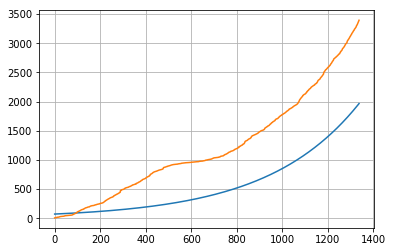

In [520]:
plt.figure(1)
plt.plot(kalmanSeriesDF['Time'], y, label="Linear")
plt.plot(kalmanSeriesDF['Time'], kalmanSeriesDF['SummedEntries'], label="Log")
plt.grid()
plt.show()

In [10]:
Hk, residualsk = goForIt(kalmanSeriesDF, 4)
Hk

[[1.0, 0], [1.0, 1], [1.0, 2], [1.0, 7]]

In [12]:
# plt.figure(1)
# plt.plot(kalmanSeriesDF['Time'], kalmanPredictNextVal(kalmanSeriesDF['Time'], x0))
# plt.grid()
# plt.show()

In [124]:
w

array([[1.76405235],
       [0.40015721]])

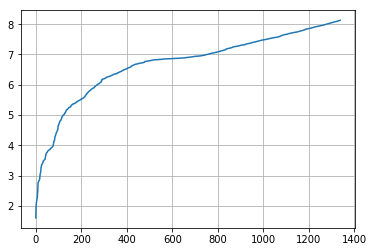

In [157]:
plt.figure(1)
plt.plot(seriesDF['InvertedTime'], seriesDF['LoggedSummedEntries'], label="Logged")
plt.grid()
plt.show()

In [63]:
x, y = modelValues(1.030016, 0.00899546, 1577)

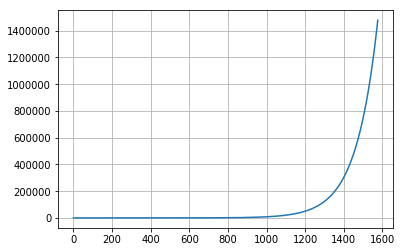

In [64]:
plt.figure(1)
plt.plot(x, y, label="Slope")
plt.grid()
plt.show()

In [62]:
# #NOTE! This is the predicted number of entrants based on the current timesetp
# def kalmanPredictFullArray(timesTillNow, xCurr):
#     n=len(timesTillNow)
# #     Vk = [[R]]*n
#     Vk = random_state.randn(n, 1)
#     Hk = [list(a) for a in zip([1.]*n, timesTillNow)] #Observation Model (?)
#     Zk = np.dot(Hk, xCurr) + Vk
# #     print(Hk)
#     return Hk, Zk
# #kalmanPredictNextVal(kalmanSeriesDF.iloc[:100]['Time'], x0)

In [63]:
# def goForItFull(series):
#     Zs = []
#     Ys = []
#     Hs = []
#     Ss = []
#     Ps = [] ## Covariance Matrix of Estimate Errors DO P PLEASE
#     Ks = [] ## Kalman Gain
#     Xs = []
    
#     pCurr = P0 #DONT FORGET TO UPDATE
#     xCurr = x0 #DONT FORGET TO UPDATE
#     for n in range (1, 4):
#         #Set new vars based on current observation
        
#         actual = np.array(series.iloc[:n]['Y'])
#         times = np.array(series.iloc[:n]['Time'])
        
        
#         Hk, Zk = kalmanPredictNextVal(kalmanSeriesDF.iloc[:n]['Time'], xCurr)
        
#         Yk = actual - np.array(Zk)[:,0] # residuals
#         currY = Yk[-1:][0]
        
#         currH = Hk[-1:][0]
#         transposedH = [[currH[0]],[currH[1]]]
        
#         Sk_part = np.dot(currH, pCurr)
#         Sk = np.dot(Sk_part, transposedH)+R
    
        
#         inverseS = 1/Sk[0]        
#         newK = np.dot(pCurr, transposedH)*inverseS
#         newX = xCurr + newK*currY
        

#         p_part = (np.eye(2)-np.outer(newK, currH))
#         newP = np.dot(p_part, pCurr)
        
#         Zs.append(Zk[-1:][0][0])
#         Ys.append(Yk[-1:][0])
#         Hs.append(Hk[-1:][0])
#         Ss.append(Sk[0])
#         Ks.append(newK[0]) ## Kalman Gain
#         Xs.append(newX[0])
#         Ps.append(newP.tolist()) 
        
#         pCurr = newP
#         xCurr = newX
    
#     return {"Zs": Zs, "Ys": Ys, "Hs":Hs, "Ss":Ss, "Ps":Ps, "Ks": Ks, "Xs": Xs}
# #         Ss.append()
# #     print("Y", Ys)
# #     print("Z", Zs)
# #     print("H", Hs)
# #     print("S", Ss)

# resultDict = goForIt(kalmanSeriesDF)